# Karen Yu, Nick Vasios, Thibaut Perol

# AM207 Final Project

## Energy Disaggregation from Non-Intrusive Load Monitoring

#  DISAGGREGATION USING COMBINATORIAL OPTIMIZATION

## Importing Necessary Packages

In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
from os.path import join
import pickle
import copy

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.utils import print_dict,find_nearest
from nilmtk.feature_detectors import cluster
from nilmtk.disaggregate import Disaggregator
from nilmtk.electric import get_vampire_power
from nilmtk.metrics import f1_score

import warnings
from warnings import warn
warnings.filterwarnings("ignore")
import seaborn as sns
# sns.set_style("white")

# Fix the seed for repeatability of experiments
SEED = 42
np.random.seed(SEED)

## The Heart of the Notebook: The Combinatorial Optimization class

In [2]:
class CombinatorialOptimisation(Disaggregator):
    """
    
    A Combinatorial Optimization Algorithm based on the implementation by NILMTK
    
    This class is build upon the main Dissagregator class already implemented by NILMTK
    All the methods from Dissagregator are passed in here as well since we import the class
    as shown above. We should note howeger that Dissagregator is nothing more than a general interface
    class upon which all dissagregator algortihms are build. All the methods are initialized in the 
    Dissagregator class but the specific implementation is based upon the method to be implemented. 
    In other words, even though we pass in Dissagregator, all methods will be redefined again to work with 
    the Combinatorial Optimization algorithm as you can see below. 

    
    Attributes
    ----------
    model : list of dicts
       Each dict has these keys:
           states : list of ints (the power (Watts) used in different states)
           training_metadata : ElecMeter or MeterGroup object used for training
               this set of states.  We need this information because we
               need the appliance type (and perhaps some other metadata)
               for each model.

    state_combinations : 2D array
        Each column is an appliance.
        Each row is a possible combination of power demand values e.g.
            [[0, 0,  0,   0],
             [0, 0,  0, 100],
             [0, 0, 50,   0],
             [0, 0, 50, 100], ...]

    MIN_CHUNK_LENGTH : int
    """

    def __init__(self):
        self.model = []
        self.state_combinations = None
        self.MIN_CHUNK_LENGTH = 100
        self.MODEL_NAME = 'Combinatorial Optimization'

    def train(self, metergroup, num_states_dict=None, **load_kwargs):
        """
        Train using 1D CO. Places the learnt model in the `model` attribute.

        Parameters
        ----------
        metergroup : a nilmtk.MeterGroup object
        num_states_dict : dict
        **load_kwargs : keyword arguments passed to `meter.power_series()`

        Notes
        -----
        * only uses first chunk for each meter (TODO: handle all chunks).
        """
        
        # Initializing dictionary to save the number of states
        if num_states_dict is None:
            num_states_dict = {}

        # The CO class is only able to train in new models. We can only train once. If model exists, raise an error
        if self.model:
            raise RuntimeError(
                "This implementation of Combinatorial Optimisation"
                " does not support multiple calls to `train`.")

        # How many meters do we have in the training set?
        num_meters = len(metergroup.meters)
        
        # If more than 20 then reduce the number of clusters to reduce the computational cost. 
        if num_meters > 20:
            max_num_clusters = 2
        else:
            max_num_clusters = 3
        
        print('Now training...')
        print('Loop in all meters begins...')
        
        # We now loop in all meters passed in in the training data set
        # Every time, we load the data in the meter and we call the method
        # --> train_on_chunk. For more info about this method please see below
        for i, meter in enumerate(metergroup.submeters().meters):
            
            #print('We now train for submeter {}'.format(meter))
            
            # Load the time series for the power consumption for this meter
            power_series = meter.power_series(**load_kwargs)
            
            # Note that we do not effectively load until we use the next() method
            # We load and save into chunk. Chunk will be used in training
            chunk = power_series.next()
            
            # Get the number of total states from the dictionary
            num_total_states = num_states_dict.get(meter)
            if num_total_states is not None:
                num_on_states = num_total_states - 1
            else:
                num_on_states = None
                
            #print('i={},num_total_states={},num_on_states={}'.format(i,meter,num_total_states,num_on_states))    
            
            # The actual training happens now. We call train_on_chunk using the time series we loaded on chunk for this meter
            self.train_on_chunk(chunk, meter, max_num_clusters, num_on_states)

            # Check to see if there are any more chunks.
            try:
                power_series.next()
            except StopIteration:
                pass
            else:
                warn("The current implementation of CombinatorialOptimisation"
                     " can only handle a single chunk.  But there are multiple"
                     " chunks available.  So have only trained on the"
                     " first chunk!")

        print("Done training!")

    def train_on_chunk(self, chunk, meter, max_num_clusters, num_on_states):
        """
        
        Train on chunk trains the Combinatorial Optimization Model based on the time series for the power consumption
        passed in chunk. This method is based on the sklearn machine learning library and in particular the KMEANS 
        algorithm. It calls the cluster function which is imported in the beginning of this notebook. Cluster, prepares 
        the data in chunk so that its size is always compatible and the same and then calls the KMEANS algorithm to 
        perform the clustering. Function cluster returns only the centers of the clustered data which correspond to the
        individual states for the given appliance/meter        
        """
        
        # Check if we've already trained on this meter. We only allow training once on each meter
        meters_in_model = [d['training_metadata'] for d in self.model]
        if meter in meters_in_model:
            raise RuntimeError(
                "Meter {} is already in model!"
                "  Can't train twice on the same meter!"
                .format(meter))

        # Do the KMEANS clustering and return the centers
        states = cluster(chunk, max_num_clusters, num_on_states)
        print('\t Now Clustering in Train on Chunk')
        #print('\t {}'.format(states))
        
        # Append the clustered data to the model
        self.model.append({
            'states': states,
            'training_metadata': meter})

    def _set_state_combinations_if_necessary(self):
        """Get centroids"""
        # If we import sklearn at the top of the file then auto doc fails.
        if (self.state_combinations is None or
                self.state_combinations.shape[1] != len(self.model)):
            
            from sklearn.utils.extmath import cartesian
            
            # Saving the centroids in centroids (appliance states)
            centroids = [model['states'] for model in self.model]
            # Function cartesian returns all possible combinations 
            # than can be performed using centroids
            self.state_combinations = cartesian(centroids)
            print()
            #print('Now printing the state combinations...')
            #print(cartesian(centroids))

    def disaggregate(self, mains, output_datastore,
                     vampire_power=None, **load_kwargs):
        '''Disaggregate mains according to the model learnt previously.

        Parameters
        ----------
        mains : nilmtk.ElecMeter or nilmtk.MeterGroup
        output_datastore : instance of nilmtk.DataStore subclass
            For storing power predictions from disaggregation algorithm.
        vampire_power : None or number (watts)
            If None then will automatically determine vampire power
            from data.  If you do not want to use vampire power then
            set vampire_power = 0.
        sample_period : number, optional
            The desired sample period in seconds.  Set to 60 by default.
        sections : TimeFrameGroup, optional
            Set to mains.good_sections() by default.
        **load_kwargs : key word arguments
            Passed to `mains.power_series(**kwargs)`
        '''
        
        # Performing default pre disaggregation checks. Checking meters etc..
        load_kwargs = self._pre_disaggregation_checks(load_kwargs)

        # Disaggregation defauls. Sample perios and sections
        load_kwargs.setdefault('sample_period', 60)
        load_kwargs.setdefault('sections', mains.good_sections())

        # Initializing time frames and fetching the meter for the aggregated data
        timeframes = []
        building_path = '/building{}'.format(mains.building())
        mains_data_location = building_path + '/elec/meter1'
        data_is_available = False
        
        # We now load the aggregated data for power consumption of the whole house in small chunks
        # Every iteration of the following loop we perform the CO step to disaggregate
        
        counter = 0
        print('Disaggregation now begins...')
        for chunk in mains.power_series(**load_kwargs):
            counter += 1
            # Check that chunk is sensible size
            if len(chunk) < self.MIN_CHUNK_LENGTH:
                continue
                
            print('\t Now processing chunk {}...'.format(counter))

            # Record metadata
            timeframes.append(chunk.timeframe)
            measurement = chunk.name

            # This is where the disaggregation happens
            # Vampire Power is just the minimum of the power series in this chunk
            appliance_powers = self.disaggregate_chunk(chunk, vampire_power)

            # Here we save the disaggregated data for this chunk in Pandas dataframe and update the 
            # HDF5 file we created.
            for i, model in enumerate(self.model):
                # Fetch the disag data for this appliance
                appliance_power = appliance_powers[i]
                if len(appliance_power) == 0:
                    continue
                data_is_available = True
                
                # Just for saving.. Nothing major happening here
                cols = pd.MultiIndex.from_tuples([chunk.name])
                meter_instance = model['training_metadata'].instance()
                df = pd.DataFrame(
                    appliance_power.values, index=appliance_power.index,
                    columns=cols)
                key = '{}/elec/meter{}'.format(building_path, meter_instance)
                output_datastore.append(key, df)

            # Copy mains data to disag output
            mains_df = pd.DataFrame(chunk, columns=cols)
            output_datastore.append(key=mains_data_location, value=mains_df)

        if data_is_available:
            self._save_metadata_for_disaggregation(
                output_datastore=output_datastore,
                sample_period=load_kwargs['sample_period'],
                measurement=measurement,
                timeframes=timeframes,
                building=mains.building(),
                meters=[d['training_metadata'] for d in self.model]
            )
        
        print('Disaggregation Completed Successfully...!!!')

    def disaggregate_chunk(self, mains, vampire_power=None):
        """In-memory disaggregation.

        Parameters
        ----------
        mains : pd.Series
        vampire_power : None or number (watts)
            If None then will automatically determine vampire power
            from data.  If you do not want to use vampire power then
            set vampire_power = 0.

        Returns
        -------
        appliance_powers : pd.DataFrame where each column represents a
            disaggregated appliance.  Column names are the integer index
            into `self.model` for the appliance in question.
        """
        if not self.model:
            raise RuntimeError(
                "The model needs to be instantiated before"
                " calling `disaggregate`.  The model"
                " can be instantiated by running `train`.")

        if len(mains) < self.MIN_CHUNK_LENGTH:
            raise RuntimeError("Chunk is too short.")

        # sklearn produces lots of DepreciationWarnings with PyTables
        import warnings
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        # Because CombinatorialOptimisation could have been trained using
        # either train() or train_on_chunk(), we must
        # set state_combinations here.
        self._set_state_combinations_if_necessary()

        # Add vampire power to the model (Min of power series of the aggregated data)
        if vampire_power is None:
            vampire_power = get_vampire_power(mains)
        if vampire_power > 0:
            print()
            #print("Including vampire_power = {} watts to model...".format(vampire_power))
            
            # How many combinations
            n_rows = self.state_combinations.shape[0]
            vampire_power_array = np.zeros((n_rows, 1)) + vampire_power
            state_combinations = np.hstack(
                (self.state_combinations, vampire_power_array))
        else:
            state_combinations = self.state_combinations

        summed_power_of_each_combination = np.sum(state_combinations, axis=1)
        # summed_power_of_each_combination is now an array where each
        # value is the total power demand for each combination of states.

        # Start disaggregation
        
        # The following line finds the best combination from all the possible combinations
        # Returns the index to find the best combination as well as the residual
        # Uses the Find_Nearest algorithm
        indices_of_state_combinations, residual_power = find_nearest(
            summed_power_of_each_combination, mains.values)

        # Now update the state for each appliance with the optimal one and return the list
        # as Dataframe
        appliance_powers_dict = {}
        for i, model in enumerate(self.model):
            #print()
            #print("Estimating power demand for '{}'".format(model['training_metadata']))
            predicted_power = state_combinations[
                indices_of_state_combinations, i].flatten()
            column = pd.Series(predicted_power, index=mains.index, name=i)
            appliance_powers_dict[i] = column

        appliance_powers = pd.DataFrame(appliance_powers_dict)
        return appliance_powers

    # The current implementation of the CO does not make use of the following 2 functions.
    #
    #
    # -------------------------------------------------------------------------------------
    def import_model(self, filename):
        imported_model = pickle.load(open(filename, 'r'))
        self.model = imported_model.model
        # recreate datastores from filenames
        for pair in self.model:
            pair['training_metadata'].store = HDFDataStore(
                pair['training_metadata'].store)
        self.state_combinations = imported_model.state_combinations
        self.MIN_CHUNK_LENGTH = imported_model.MIN_CHUNK_LENGTH

    def export_model(self, filename):
        # Can't pickle datastore, so convert to filenames
        exported_model = copy.deepcopy(self)
        for pair in exported_model.model:
            pair['training_metadata'].store = (
                pair['training_metadata'].store.store.filename)
        pickle.dump(exported_model, open(filename, 'wb'))

## Importing and Loading the REDD dataset

In [3]:
data_dir = '\Users\Nick\Google Drive\PhD\Courses\Semester 2\AM207\Project'
we = DataSet(join(data_dir, 'REDD.h5'))
print('loaded ' + str(len(we.buildings)) + ' buildings')

loaded 6 buildings


We want to train the Combinatorial Optimization Algorithm using the data for 5 buildings and then test it against the last building. To simplify our analysis and also to enable comparison with other methods (Neural Nets, FHMM, MLE etc) we will only try to dissagregate data associated with the fridge and the microwave. However, the REDD dataset that we are using here does not contain data measurements for the fridge and microwave for all buildings. In particular, building 4 does not have measurements for the fridge. As a result, we will exclude building 4 from the dataset and we will only import the meters associated with the fridge from other buildings. 

The train data set will consist of meters associated with the fridge and microwave from buildings 1,2,3 and 6. We will then test the combinatorial optimization algorithm against the aggregated data for building 5. 


We first plot the time window span for all buildings

In [4]:
for i in xrange(1,7):
    print('Timeframe for building {} is {}'.format(i,we.buildings[i].elec.get_timeframe()))    

Timeframe for building 1 is TimeFrame(start='2011-04-18 09:22:09-04:00', end='2011-05-24 15:57:02-04:00', empty=False)
Timeframe for building 2 is TimeFrame(start='2011-04-17 19:18:27-04:00', end='2011-05-22 19:59:16-04:00', empty=False)
Timeframe for building 3 is TimeFrame(start='2011-04-16 01:11:27-04:00', end='2011-05-30 20:19:54-04:00', empty=False)
Timeframe for building 4 is TimeFrame(start='2011-04-16 21:16:19-04:00', end='2011-06-03 20:45:45-04:00', empty=False)
Timeframe for building 5 is TimeFrame(start='2011-04-18 00:24:03-04:00', end='2011-05-31 20:20:20-04:00', empty=False)
Timeframe for building 6 is TimeFrame(start='2011-05-21 15:39:19-04:00', end='2011-06-14 01:31:44-04:00', empty=False)


Unfortunately, due to a bug in one of the main classes of the NILMTK package the implementation of the Combinatorial Optimization do not save the meters for the disaggregated data correctly unless the building on which we test on also exists in the trainihg set. More on this issue can be found here https://github.com/nilmtk/nilmtk/issues/194

However, for us it makes no sense to use the same building for training and testing since we would like to compare this algorithm with the results from FHMM and Neural Networks. In order to circumvent this bug we do the following:

The main issue is that the meter for the building we would like to disaggregate must be on the training set in order to be able to disaggregate correctly. That being said, we still want to train as less as possible on the meter we want to test on since we would like to see how the algorithm performs when a completely unknown dataset is available. In order to do that we create a metergroup comprising of the following:

1) The meters for the Frigde and Microwave for all buildings but building 5, since building 5 is the building we would like to test on. Later we will see that building 4 needs to be excluded as well because there is no meter associated with the fridge for this building. 

2) The meters for the Frigde and Microwave for building 5 which is the building we would like to test on, but we limit the time window to be a very very small one. Doing that, we make sure that the meters are there and understood by the Combinatorial Optimization Class but at the same time, by limiting the time window to just a few housrd for this building do not provide enough data to overtrain. In other words, we only do this in order to be able to disaggregate correctly. 

After we train we will test the algorithm against the data from building 5 that werent fed into the training meters. After we disaggregate we will compare with the ground truth for the same exact window. 

## Modifying Datasets to work with CO

In [5]:
# Data file directory
data_dir = '\Users\Nick\Google Drive\PhD\Courses\Semester 2\AM207\Project'

# Make the Data set
Data = DataSet(join(data_dir, 'REDD.h5'))

# Make copies of the Data Set so that local changes would not affect the global dataset
Data_for_5 = DataSet(join(data_dir, 'REDD.h5'))
Data_for_rest = DataSet(join(data_dir, 'REDD.h5'))

# How many buildings in the data set?
print(' Found {} buildings in the Data Ser.. Buildings Loaded successfully.'.format(len(Data.buildings)))

 Found 6 buildings in the Data Ser.. Buildings Loaded successfully.


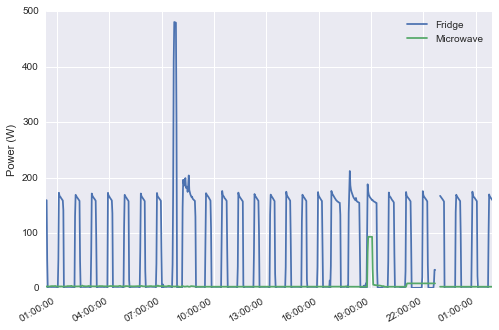

In [6]:
# This is the point that we will break the data from building 5 so that we only include a small 
# portion in the training set. In fact, the line below makes sure than only a day of data is seen during training.
break_point = '2011-04-19 02:00'

# Changing the window for building 5
Data_for_5.set_window(end=break_point)

# Making a metergroup..
e = [Data_for_5.buildings[5].elec[a] for a in ['fridge','microwave']]
me = MeterGroup(e)

# The data that we pass in for training for building 5 look like this...
me.plot()

## Creating MeterGroups with the desired appliances from the desired buildings

Below we define a function tha is able to create a metergroup that only includes meters for the appliances that we are interested in and is also able to exclude buildings that we don't want in the meter. Also, if an appliance is requested but a meter is not found then the meter is skipped but the metergoup is created nontheless.

In [7]:
def get_all_trainings(appliance, dataset, buildings_to_exclude):

    # Filtering by appliances: 
    elecs = []
    for app in appliance:
        app_l = [app]
        print ('Now loading data for ' + app + ' for all buildings in the data to create the metergroup')
        print()
        for building in dataset.buildings: 
            if building not in buildings_to_exclude:
                print ('Processing Building ' + str(building) + '...')
                print()
                try:
                    elec = dataset.buildings[building].elec[app]       
                    
                    elecs.append(elec)

                except KeyError:
                    print ('Appliance '+str(app)+' does not exist in this building')
                    print ('Building skipped...')
                    print ()
            

    metergroup = MeterGroup(elecs)

    return metergroup

Now we set the appliances that we want as well as the buildings to exclude and we create the metergroup

In [8]:
applianceName = ['fridge','microwave']
buildings_to_exclude = [4,5]

metergroup = get_all_trainings(applianceName,Data_for_rest,buildings_to_exclude)

print('Now printing the Meter Group...')
print()
print(metergroup)

Now loading data for fridge for all buildings in the data to create the metergroup

Processing Building 1...

Processing Building 2...

Processing Building 3...

Processing Building 6...

Now loading data for microwave for all buildings in the data to create the metergroup

Processing Building 1...

Processing Building 2...

Processing Building 3...

Processing Building 6...

Appliance microwave does not exist in this building
Building skipped...

Now printing the Meter Group...

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=6, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='mic

As we can see the Metergroup was successfully created and contains all the appliances we requested (Fridge and Microwave) in all buildings that the appliances exist apart from the ones we excluded

## Correcting the MeterGroup (Necessary for the CO to work)

Now we need to perform the trick we mentioned previously. We need to also include the meter from building 5 with the Fridge and Microwave which is the building we are going to test on but we need to make sure that only a very small portion of the data is seen for this building. We already took care of that by changing the window for the data in building 5 so now we only have to include the meters for the Fridge and Microwave for building 5 from the reduced time dataset

In [9]:
def correct_meter(Data,building,appliance,oldmeter):
    
    # Unpack meters from the MeterGroup
    meters = oldmeter.all_meters()
    
    # Get the rest of the meters and append
    for a in appliance:
        meter_to_add = Data.buildings[building].elec[a]
        meters.append(meter_to_add)
    
    # Group again in a single metergroup and return
    return MeterGroup(meters)   

In [10]:
corr_metergroup = correct_meter(Data_for_5,5,applianceName,metergroup)

In [11]:
print('The Modified Meter is now..')
print()
print(corr_metergroup)

The Modified Meter is now..

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=9, building=2, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=7, building=3, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=8, building=6, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=6, building=2, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=16, building=3, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=18, building=5, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=5, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
)


As we can see the metergroup was updated successfully

## Training

We now need to train in the Metergroup we just created. First, let us load the class for the CO

In [12]:
# Train
co = CombinatorialOptimisation()

Now Let's train

In [13]:
co.train(corr_metergroup)

Now training...
Loop in all meters begins...
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
	 Now Clustering in Train on Chunk
Done training!


## Preparing the Testing Data

Now that the training is done, the only thing that we have to do is to prepare the Data for Building 5 that we want to test on and call the Disaggregation. The data set is now the remaining part of building 5 that is not seen. After that, we only keep the Main meter which contains ifrormation about the aggregated data consumption and we disaggregate.

In [14]:
Test_Data = DataSet(join(data_dir, 'REDD.h5'))
Test_Data.set_window(start=break_point)

In [15]:
# The building number on which we test
building_for_testing = 5

test = Test_Data.buildings[building_for_testing].elec

In [16]:
mains = test.mains()

## Disaggregating the test data

The disaggregation Begins Now

In [17]:
# Disaggregate
disag_filename = join(data_dir, 'COMBINATORIAL_OPTIMIZATION.h5')

mains = test.mains()

try:
    output = HDFDataStore(disag_filename, 'w')
    co.disaggregate(mains, output)
except ValueError:
    output.close()
    output = HDFDataStore(disag_filename, 'w')
    co.disaggregate(mains, output)

for meter in range(1, 2):
    df1 = output.store.get('/building5/elec/meter{}'.format(meter))
    df2 = we.store.store.get('/building5/elec/meter{}'.format(meter))

    
output.close()

Disaggregation now begins...
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
	 Now processing chunk 2...


Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
Loading data for meter ElecMeterID(instance=2, building=5, dataset='REDD')     
Done loading data all meters for this chunk.
	 Now processing chunk 7...

Loading data for meter ElecMeterID(in

OK.. Now we are all done. All that remains is to interpret the results and plot the scores..

## Post Processing & Results

In [18]:
# Opening the Dataset with the Disaggregated data
disag = DataSet(disag_filename)

# Getting electric appliances and meters
disag_elec = disag.buildings[building_for_testing].elec

# We also get the electric appliances and meters for the ground truth data to compare
elec = Test_Data.buildings[building_for_testing].elec

e = [test[a] for a in applianceName]
me = MeterGroup(e)
print(me)

MeterGroup(meters=
  ElecMeter(instance=18, building=5, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=5, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
)


### Resampling to align meters

Before we are able to calculate and plot the metrics we need to align the ground truth meter with the disaggregated meters. Why so? If you notice in the dissagregation method of the CO class above, you may see that by default the time sampling is changed from 3s which is the raw data to 60s. This has to happen in order to make the disaggregation more efficient computationally but also because it is impossible to disaggregate using the actual time step. So in order to compare now we have to resample the meter for the ground truth and align it

In [19]:
def align_two_meters(master, slave, func='when_on'):
    """Returns a generator of 2-column pd.DataFrames.  The first column is from
    `master`, the second from `slave`.

    Takes the sample rate and good_periods of `master` and applies to `slave`.

    Parameters
    ----------
    master, slave : ElecMeter or MeterGroup instances
    """
    sample_period = master.sample_period()
    period_alias = '{:d}S'.format(sample_period)
    sections = master.good_sections()
    master_generator = getattr(master, func)(sections=sections)
    for master_chunk in master_generator:
        if len(master_chunk) < 2:
            return
        chunk_timeframe = TimeFrame(master_chunk.index[0],
                                    master_chunk.index[-1])
        slave_generator = getattr(slave, func)(sections=[chunk_timeframe])
        slave_chunk = next(slave_generator)

        # TODO: do this resampling in the pipeline?
        slave_chunk = slave_chunk.resample(period_alias)
        if slave_chunk.empty:
            continue
        master_chunk = master_chunk.resample(period_alias)

    return master_chunk,slave_chunk


Here we just plot the disaggregated data alongside the ground truth for the Fridge

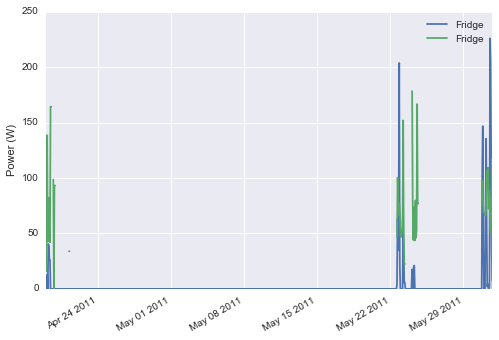

In [20]:
disag_elec.select(instance=18).plot()
me.select(instance=18).plot()

### Aligning meters, Converting to Numpy and Computing Metrics

In this part of the Notebook, we call the function we previously defined to align the meters and then we convert the meters to pandas and ultimately to numpy arrays. We check if any NaN's exist (which is something possible after resmplilng.. Resampling errors may occur) and replace them with 0's if they do. We also compute the following metrics for each appliance:

1) True Positive, False Positive, False Negative, True Negative

2) Precision and Recall

3) Accuracy and F1-Score

For more information about these metrics please refer to the report.

In [21]:
appliances_scores = {}

In [22]:
for m in me.meters:
    print('Processing {}...'.format(m.label()))
    ground_truth = m
    inst = m.instance()
    prediction = disag_elec.select(instance=inst)
    
    a = prediction.meters[0]
    
    b = a.power_series_all_data()
    
    pr_a,gt_a = align_two_meters(prediction.meters[0],ground_truth)
    
    gt = gt_a.as_matrix()
    pr = pr_a.as_matrix()
    
    if np.all(np.isnan(pr)==False):
        print('\t Predictions array seems to be fine...')
        print('\t No Nans detected')
        print()
    else:
        print('\t Serious error in Predictions...')
        print('\t The resampled array contains Nans')
        print()
    
    gt_states_on = gt > 0.1
    pr_states_on = pr > 0.1
    
    TP = np.sum(np.logical_and(gt_states_on==True,pr_states_on[1:]==True))
    FP = np.sum(np.logical_and(gt_states_on==True,pr_states_on[1:]==False))
    FN = np.sum(np.logical_and(gt_states_on==False,pr_states_on[1:]==True))
    TN = np.sum(np.logical_and(gt_states_on==False,pr_states_on[1:]==False))
    P = np.sum(gt_states_on==True)
    N = np.sum(gt_states_on==False)
    
    recall = TP/float(TP+FN)
    precision = TP/float(TP+FP)
    f1 = 2*precision*recall/(precision+recall)
    accuracy = (TP+TN)/float(P+N)
    
    result = {'F1-Score':f1,
             'Precision':precision,
             'Recall':recall,
             'Accuracy':accuracy}
    appliances_scores[m.label()] = result

Processing Fridge...
	 Predictions array seems to be fine...
	 No Nans detected

Processing Microwave...
	 Predictions array seems to be fine...
	 No Nans detected



In [23]:
print(appliances_scores)

{'Fridge': {'Recall': 0.51383399209486169, 'F1-Score': 0.2810810810810811, 'Precision': 0.19345238095238096, 'Accuracy': 0.52363896848137537}, 'Microwave': {'Recall': 0.11328976034858387, 'F1-Score': 0.18118466898954702, 'Precision': 0.45217391304347826, 'Accuracy': 0.66332378223495703}}


In [24]:
Names = ['Fridge','Microwave']

### Results

Now we just plot the scores for both the Fridge and the Microwave in order to be able to visualize what is going on. We do not comment on the results in this notebook since we do this in the report. There is a separate notebook where all these results are combined along with the corresponding results from the Neural Network and the FHMM method and the total results are reported side by side to ease comparison. We plot them here as well for housekeeping although it is redundant.

#### F1-Score

In [25]:
x = np.arange(2)
y = np.array([appliances_scores[i]['F1-Score'] for i in Names])
y[np.isnan(y)] = 0.001

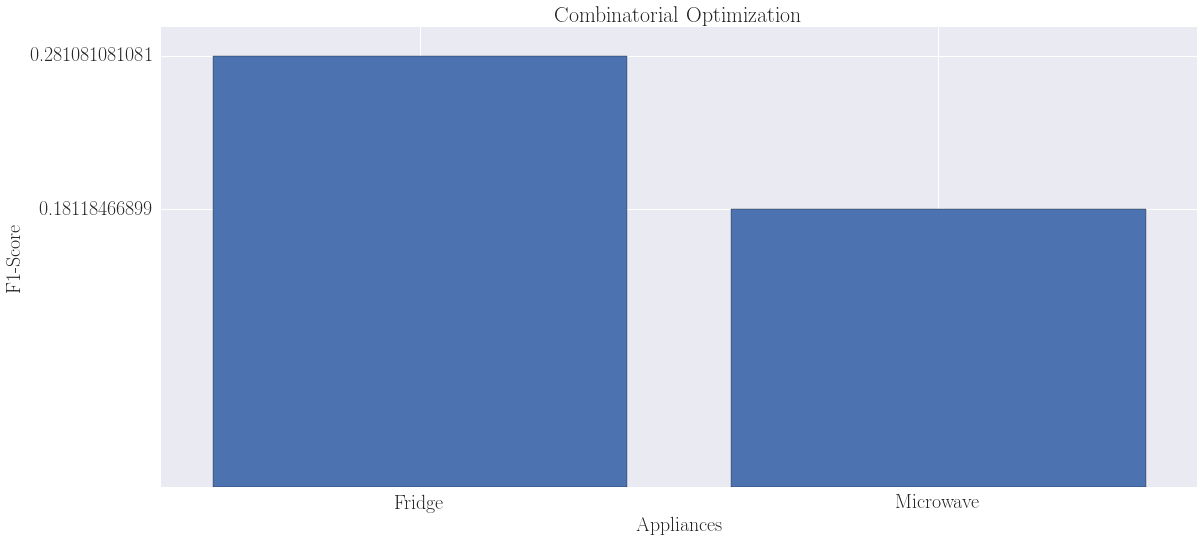

In [26]:
f = plt.figure(figsize=(18,8))
plt.rc('font', size=20, **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
ax = f.add_axes([0.2,0.2,0.8,0.8])
ax.bar(x,y,align='center')
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_yticklabels(y,fontsize=20)
ax.set_xticklabels(Names,fontsize=20)
ax.set_xlim([min(x)-0.5,max(x)+0.5])
plt.xlabel('Appliances',fontsize=20)
plt.ylabel('F1-Score',fontsize=20)
plt.title('Combinatorial Optimization',fontsize=22)
plt.show()

#### Precision

In [27]:
x = np.arange(2)
y = np.array([appliances_scores[i]['Precision'] for i in Names])
y[np.isnan(y)] = 0.001

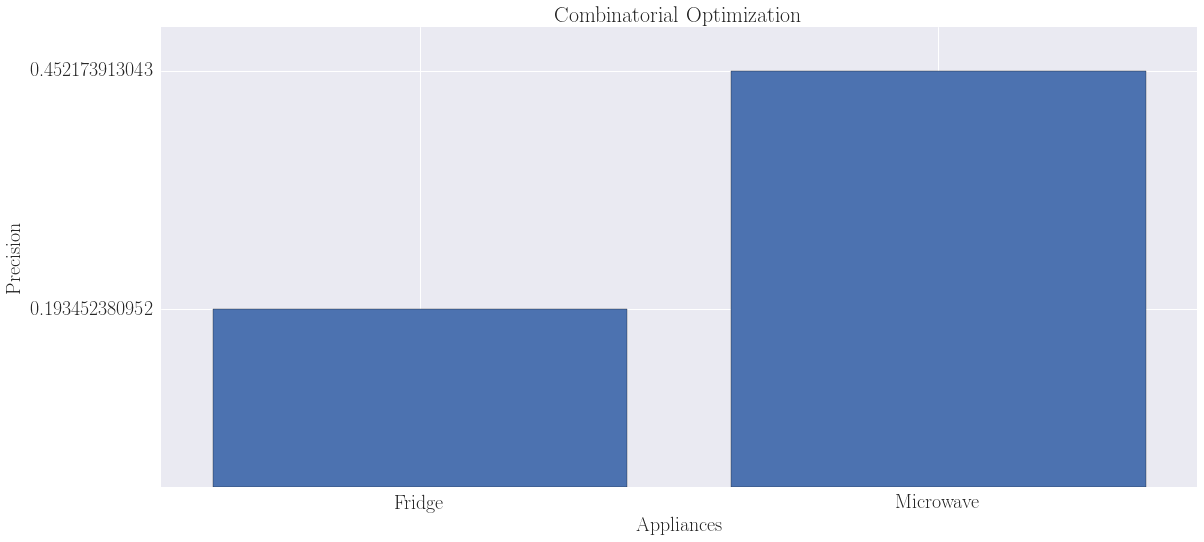

In [28]:
f = plt.figure(figsize=(18,8))
plt.rc('font', size=20, **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
ax = f.add_axes([0.2,0.2,0.8,0.8])
ax.bar(x,y,align='center')
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_yticklabels(y,fontsize=20)
ax.set_xticklabels(Names,fontsize=20)
ax.set_xlim([min(x)-0.5,max(x)+0.5])
plt.xlabel('Appliances',fontsize=20)
plt.ylabel('Precision',fontsize=20)
plt.title('Combinatorial Optimization',fontsize=22)
plt.show()

#### Recall

In [29]:
x = np.arange(2)
y = np.array([appliances_scores[i]['Recall'] for i in Names])
y[np.isnan(y)] = 0.001

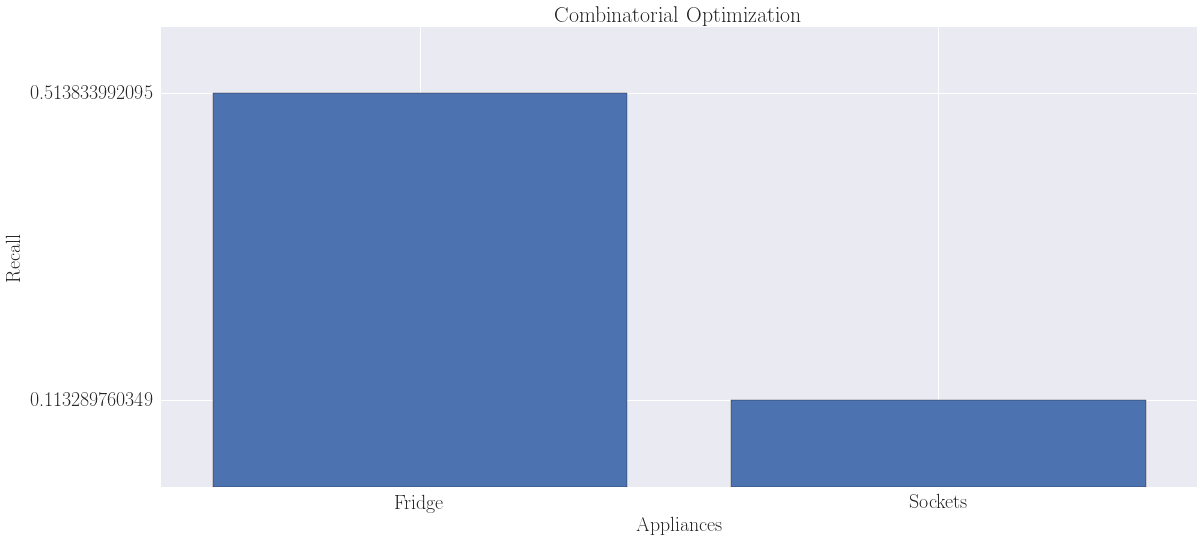

In [30]:
f = plt.figure(figsize=(18,8))
plt.rc('font', size=20, **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
ax = f.add_axes([0.2,0.2,0.8,0.8])
ax.bar(x,y,align='center')
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_yticklabels(y,fontsize=20)
ax.set_xticklabels(['Fridge','Sockets','Lights'],fontsize=20)
ax.set_xlim([min(x)-0.5,max(x)+0.5])
plt.xlabel('Appliances',fontsize=20)
plt.ylabel('Recall',fontsize=20)
plt.title('Combinatorial Optimization',fontsize=22)
plt.show()

#### Accuracy

In [31]:
x = np.arange(2)
y = np.array([appliances_scores[i]['Accuracy'] for i in Names])
y[np.isnan(y)] = 0.001

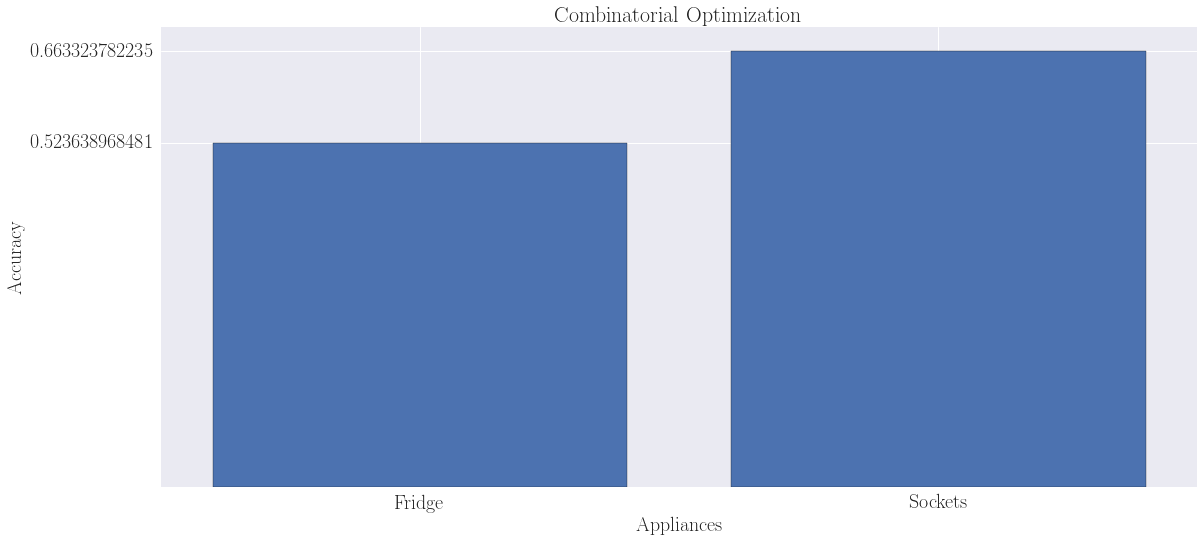

In [32]:
f = plt.figure(figsize=(18,8))
plt.rc('font', size=20, **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)
ax = f.add_axes([0.2,0.2,0.8,0.8])
ax.bar(x,y,align='center')
ax.set_xticks(x)
ax.set_yticks(y)
ax.set_yticklabels(y,fontsize=20)
ax.set_xticklabels(['Fridge','Sockets','Lights'],fontsize=20)
ax.set_xlim([min(x)-0.5,max(x)+0.5])
plt.xlabel('Appliances',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.title('Combinatorial Optimization',fontsize=22)
plt.show()